[**LINK TO COLAB**](https://colab.research.google.com/drive/1LWKqa8_JnoXSeVGYlJyqpYb0SV6wKajO)

# **The Stokes equations**
**Edvin von Platen**

# **Abstract**
In this report we solve the Stokes equations in $2D$ using FEniCS. We verify that the solution is stable using Taylor-Hood approximation spaces and unstable with equal-order linear spaces. The equal-order solution is then stabilized by introducing a Brezzi-Pitkäranta stabilization term.

# **About the code**

In [25]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Edvin von Platen (edvinvp@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. 

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 

The solution for equal-order linear approximation spaces is stabilized by introducing a Brezzi-Pitkäranta term.

All material is from the KTH course Advanced Computation in Fluid Dynamics  [DD2365.](https://kth.instructure.com/courses/17071)


# **Method**

**Define domain and mesh**

We start by setting the resolution to $32$ to get a mesh size of $h=\frac{1}{32}$. A rectangle mesh is then generated with a circle centered at the origin with radius $0.2$ cut out.

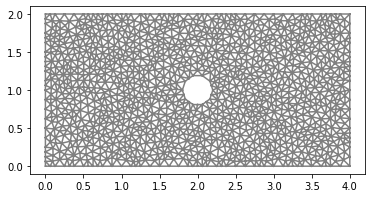

In [27]:
# Define rectangular domain 
L = 4
H = 2

# Change resolution to h = 1/32
resolution = 32
# Domain is a channel with a circle in the middle
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)

plt.figure()
plot(mesh)
plt.show()

We refine all points $p \in \Omega$ such that its distance to the origen is less than one.

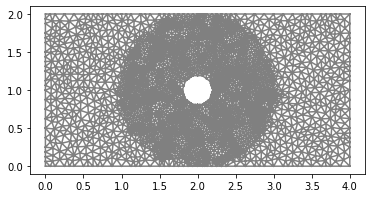

In [28]:
# Local mesh refinement (specified by a cell marker)
# Want to refine once in a radius of 1 centered at the circle
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    # Refine around the center hole with a radious of one
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)
plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

One finite element approximation space is defined using the Taylor-Hood mixed elemetnt, i.e. piecewise quadratic for the velocity and piecewise linear for the pressure. Another set of spaces are also defined where both velocity and pressure are approximated using piecewise linears as we want to first verify that it is not stable, and then stabilize it by introducing a Brezzi-Pitkäranta stabilization term.

In [0]:
# Generate mixed finite element spaces (for velocity and pressure)
# Also define VE for piecewise linears to verify Taylor-Hood
VE_linear = VectorElement("CG", mesh.ufl_cell(), 1)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE_linear = VE_linear * QE
WE = VE * QE

W = FunctionSpace(mesh, WE)
W_linear = FunctionSpace(mesh, WE_linear)
V = FunctionSpace(mesh, VE)
V_linear = FunctionSpace(mesh, VE_linear)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
w_linear = Function(W_linear)

(u_l, p_l) = (as_vector((w_linear[0],w_linear[1])), w_linear[2])
(v_l, q_l) = TestFunctions(W_linear) 

(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

**Define boundary conditions and reverse flow**

To reverse the direction of the flow the sign of the inflow condition $uin$ is changed.

In [0]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
uin_reversed = -uin
uin_linear =  Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V_linear.ufl_element())

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
# Do not need sepearate for verifying Taylor-Hood
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**


The variational problem on residual form is:
\begin{align}
r(u,p;v,q) &= \int_\Omega (-p\nabla \cdot v + (\nabla u, \nabla v) + \nabla \cdot (u)q - (f,v))dx \\
& + \gamma \int_{\partial \Omega} (ib(u + uin, v) + wb(u,v))ds = 0
\end{align}

We solve for the Taylor-Hood mixed element and equal-order elements. A solution where the flow direction is reverssed is also computed for the Taylor-Hood elements.

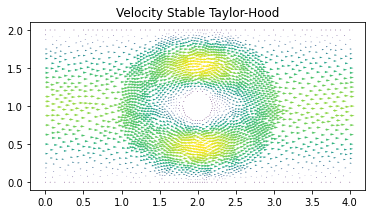

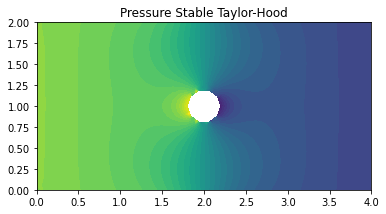

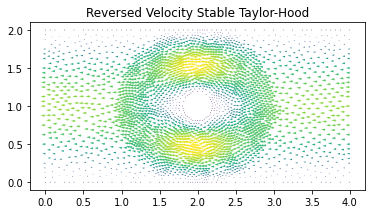

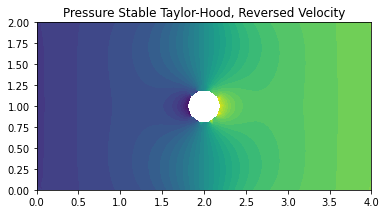

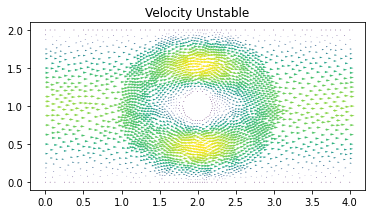

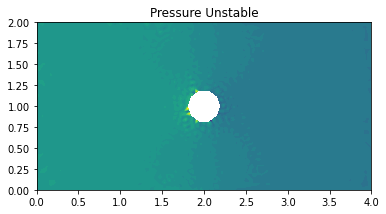

In [31]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())
f_l = Expression(("0.0","0.0"), element = V_linear.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

residual_reversed = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + 
            gamma*(ib*inner(u - uin_reversed, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

residual_linear = ( - p_l*div(v_l)*dx + inner(grad(u_l), grad(v_l))*dx + div(u_l)*q_l*dx + 
            gamma*(ib*inner(u_l - uin_linear, v_l) + wb*inner(u_l, v_l))*ds - inner(f_l, v_l)*dx)

# Solve algebraic system 
solve(residual == 0, w)
solve(residual_linear == 0, w_linear)

u1 = project(u, V)
p1 = project(p, Q)

u1_linear = project(u_l, V_linear)
p1_linear = project(p_l, Q)

plt.figure()
plot(u1, title="Velocity Stable Taylor-Hood")

plt.figure()
plot(p1, title="Pressure Stable Taylor-Hood")

solve(residual_reversed == 0, w)

u1 = project(u, V)
p1 = project(p, Q)

plt.figure()
plot(u1, title="Reversed Velocity Stable Taylor-Hood")

plt.figure()
plot(p1, title="Pressure Stable Taylor-Hood, Reversed Velocity")

plt.figure()
plot(u1_linear, title="Velocity Unstable")

plt.figure()
plot(p1_linear, title="Pressure Unstable")
        
plt.show()

When the flow is left to right, the pressure decreases as the flow passes the circle. Reversed flow gives reversed pressure. Using equal order approximation spaces makes the pressure almost uniform, there are also visible artifacts, especially at the circle boundary.

We now implement Brezzi-Pitkäranta stabilization by adding the stabilization term $S(P,q) = C \int_\Omega h^2 \nabla P \cdot \nabla q dx, \ \ C > 0 \in R^n$ to the residual, $C=1$ is used. We verify that equal order approximation spaces are now stable.

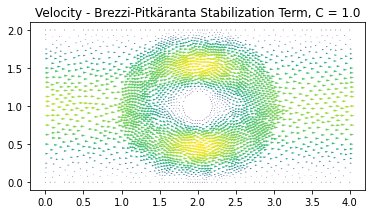

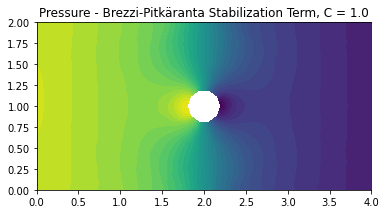

In [32]:
C = 1.0
residual_linear_brezzi = ( - p_l*div(v_l)*dx + inner(grad(u_l), grad(v_l))*dx + div(u_l)*q_l*dx + 
            gamma*(ib*inner(u_l - uin_linear, v_l) + wb*inner(u_l, v_l))*ds - inner(f_l, v_l)*dx + C*h*h*inner(grad(p_l),grad(q_l))*dx )

solve(residual_linear_brezzi == 0, w_linear)

u1_linear = project(u_l, V_linear)
p1_linear = project(p_l, Q)

plt.figure()
plot(u1_linear, title="Velocity - Brezzi-Pitkäranta Stabilization Term, C = 1.0")

plt.figure()
plot(p1_linear, title="Pressure - Brezzi-Pitkäranta Stabilization Term, C = 1.0")

plt.show()

The pressure appears to be stable. Compared to the Taylor-Hood elements there appears to be a greater range of pressure value.

# **Discussion**

A Taylor-Hood and a equal-order, stabilized with a Brezzi-Pitkäranta stabilization term, mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a number of circular obstacles, and the solution behaved as expected.  